In [8]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

import tensorflow as tf

In [9]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

# Benchmark: Simple Likelihood, Complex Posterior (SLCP)

A more challenging version of the original SLCP. This one features 92 distractor variables, unrelated to the original summary statistics.

In [10]:
benchmark_name = 'slcp_distractors'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the slcp_distractors model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [11]:
# Use a small summary network for summarizing the data
summary_net = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

In [13]:
settings = {
    'spline': {'dropout_prob': 0.3},
    'affine': {'dropout_prob': 0.3, 
               'dense_args': dict(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-4))}
}

amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(
        inference_net=InvertibleNetwork(
            num_params=5, 
            coupling_design='interleaved',
            coupling_settings=settings,
            permutation='learnable'
        ), 
        summary_net=summary_net),
    AmortizedLikelihood(
        InvertibleNetwork(
            num_params=100, 
            coupling_design='interleaved',
            coupling_settings=settings
        )
    )
)

In [14]:
config = partial(benchmark.configurator, as_summary_condition=True)
trainer = Trainer(
    amortizer=amortizer,
    default_lr=5e-4,
    generative_model=benchmark.generative_model,
    configurator=config,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall-clock time on GPU: 41min 39s

In [15]:
EPOCHS = 60
SIMULATION_BUDGET = 10000
BATCH_SIZE = 32
N_VAL = 300

train_data = trainer.generative_model(SIMULATION_BUDGET)

In [16]:
%%time
h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

INFO:root:Generated 300 simulations for validation.


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Post.Loss: 9.640, Lik.Loss: 14.292


Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Post.Loss: 9.439, Lik.Loss: 11.540


Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Post.Loss: 9.227, Lik.Loss: 10.802


Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Post.Loss: 9.065, Lik.Loss: 10.302


Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Post.Loss: 8.740, Lik.Loss: 10.054


Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Post.Loss: 8.596, Lik.Loss: 9.726


Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Post.Loss: 8.528, Lik.Loss: 9.244


Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Post.Loss: 8.359, Lik.Loss: 8.719


Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Post.Loss: 8.384, Lik.Loss: 8.159


Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Post.Loss: 8.251, Lik.Loss: 7.847


Training epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Post.Loss: 8.179, Lik.Loss: 7.564


Training epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Post.Loss: 8.122, Lik.Loss: 7.262


Training epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Post.Loss: 8.040, Lik.Loss: 7.064


Training epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Post.Loss: 7.978, Lik.Loss: 6.907


Training epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Post.Loss: 7.987, Lik.Loss: 6.811


Training epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Post.Loss: 7.915, Lik.Loss: 6.592


Training epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Post.Loss: 7.888, Lik.Loss: 6.663


Training epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Post.Loss: 7.903, Lik.Loss: 6.559


Training epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Post.Loss: 7.898, Lik.Loss: 6.339


Training epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Post.Loss: 7.824, Lik.Loss: 6.337


Training epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Post.Loss: 7.807, Lik.Loss: 6.254


Training epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Post.Loss: 7.756, Lik.Loss: 6.251


Training epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Post.Loss: 7.856, Lik.Loss: 6.334


Training epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Post.Loss: 7.776, Lik.Loss: 6.228


Training epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Post.Loss: 7.755, Lik.Loss: 6.082


Training epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Post.Loss: 7.719, Lik.Loss: 6.266


Training epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Post.Loss: 7.711, Lik.Loss: 6.225


Training epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Post.Loss: 7.692, Lik.Loss: 6.267


Training epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Post.Loss: 7.676, Lik.Loss: 6.202


Training epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Post.Loss: 7.665, Lik.Loss: 6.131


Training epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Post.Loss: 7.648, Lik.Loss: 6.112


Training epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Post.Loss: 7.652, Lik.Loss: 6.130


Training epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Post.Loss: 7.649, Lik.Loss: 6.145


Training epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Post.Loss: 7.632, Lik.Loss: 6.024


Training epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Post.Loss: 7.660, Lik.Loss: 6.145


Training epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Post.Loss: 7.623, Lik.Loss: 6.205


Training epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Post.Loss: 7.611, Lik.Loss: 6.262


Training epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Post.Loss: 7.633, Lik.Loss: 6.312


Training epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Post.Loss: 7.605, Lik.Loss: 6.258


Training epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Post.Loss: 7.577, Lik.Loss: 6.267


Training epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Post.Loss: 7.586, Lik.Loss: 6.235


Training epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Post.Loss: 7.592, Lik.Loss: 6.279


Training epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Post.Loss: 7.582, Lik.Loss: 6.335


Training epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Post.Loss: 7.575, Lik.Loss: 6.329


Training epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Post.Loss: 7.556, Lik.Loss: 6.286


Training epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Post.Loss: 7.555, Lik.Loss: 6.324


Training epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Post.Loss: 7.546, Lik.Loss: 6.366


Training epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Post.Loss: 7.549, Lik.Loss: 6.354


Training epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Post.Loss: 7.540, Lik.Loss: 6.378


Training epoch 50:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Post.Loss: 7.543, Lik.Loss: 6.360


Training epoch 51:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Post.Loss: 7.545, Lik.Loss: 6.360


Training epoch 52:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Post.Loss: 7.542, Lik.Loss: 6.346


Training epoch 53:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Post.Loss: 7.547, Lik.Loss: 6.337


Training epoch 54:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Post.Loss: 7.542, Lik.Loss: 6.391


Training epoch 55:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Post.Loss: 7.540, Lik.Loss: 6.351


Training epoch 56:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Post.Loss: 7.540, Lik.Loss: 6.350


Training epoch 57:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Post.Loss: 7.539, Lik.Loss: 6.348


Training epoch 58:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Post.Loss: 7.541, Lik.Loss: 6.351


Training epoch 59:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Post.Loss: 7.541, Lik.Loss: 6.353


Training epoch 60:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Post.Loss: 7.540, Lik.Loss: 6.353


CPU times: user 38min 41s, sys: 7min 57s, total: 46min 39s
Wall time: 26min 20s


# Validation

## Loss Trajectories

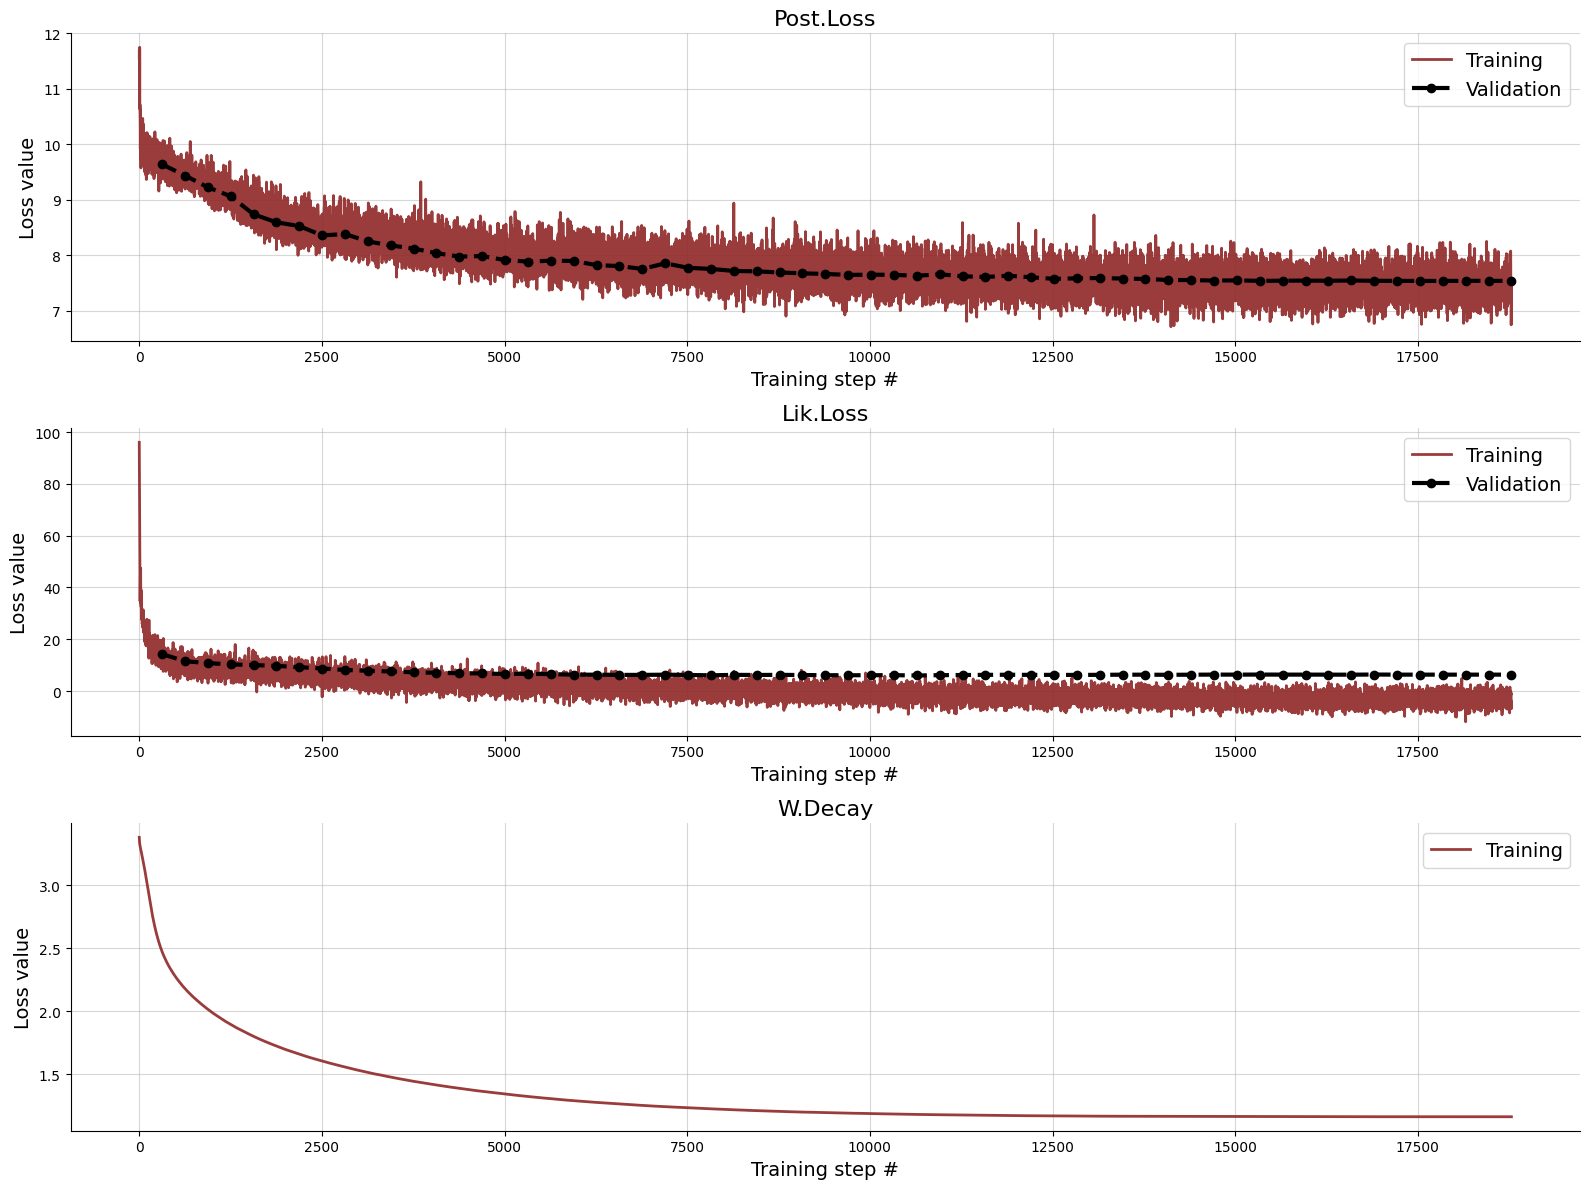

In [17]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

In [18]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [19]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'summary_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

## Individual ECDF Calibration Plots

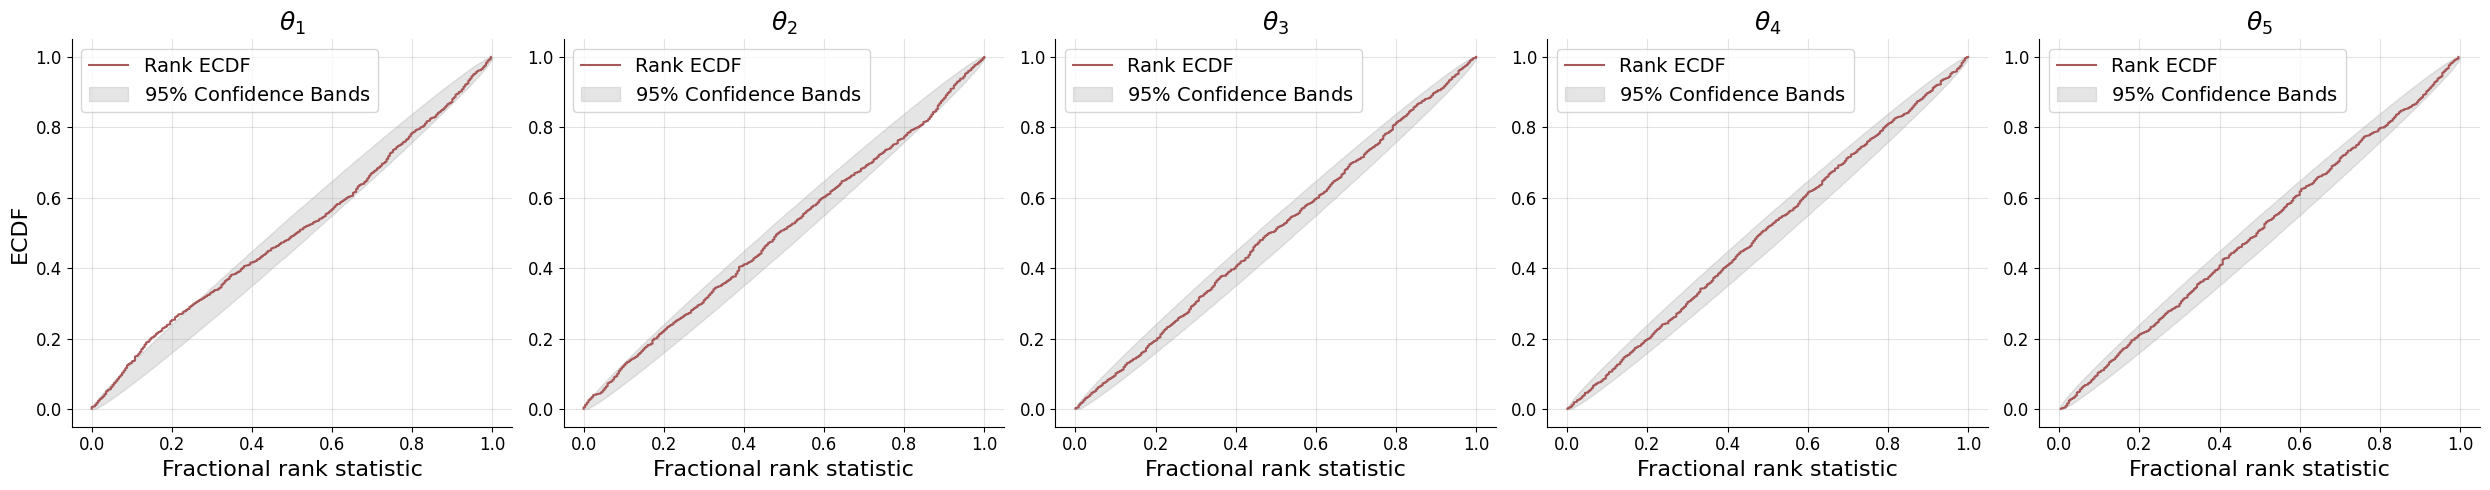

In [20]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95))

## Recovery
Observe the hints for bimodality!

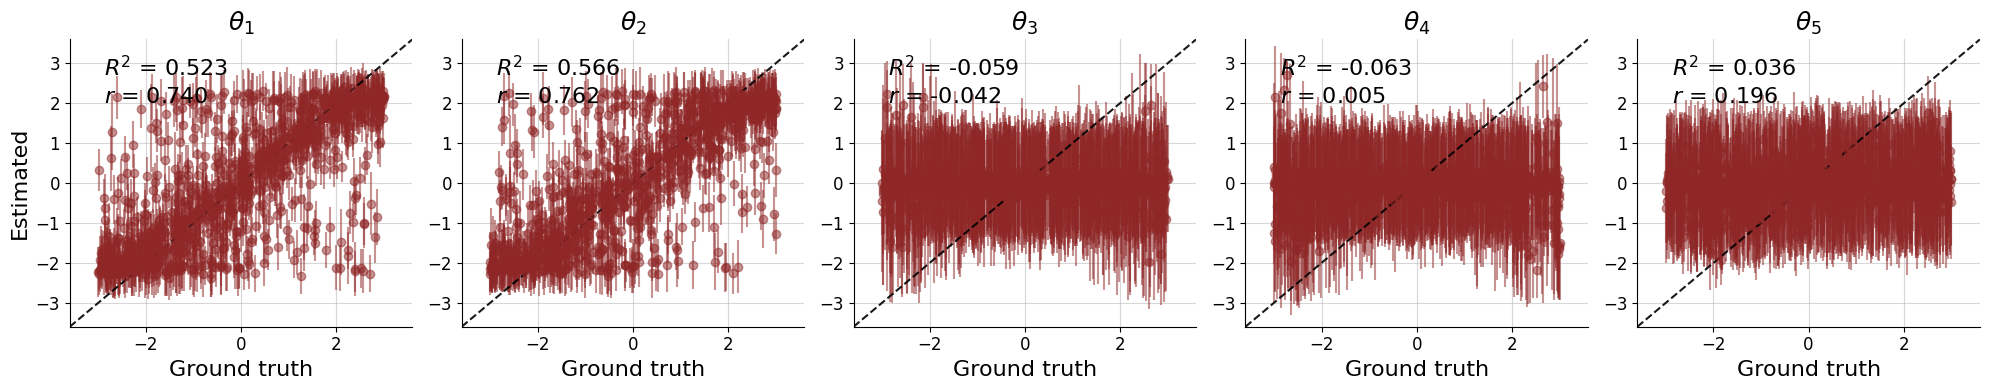

In [21]:
f = plot_recovery(post_samples, prior_samples)

### Example Bivariate Posteriors

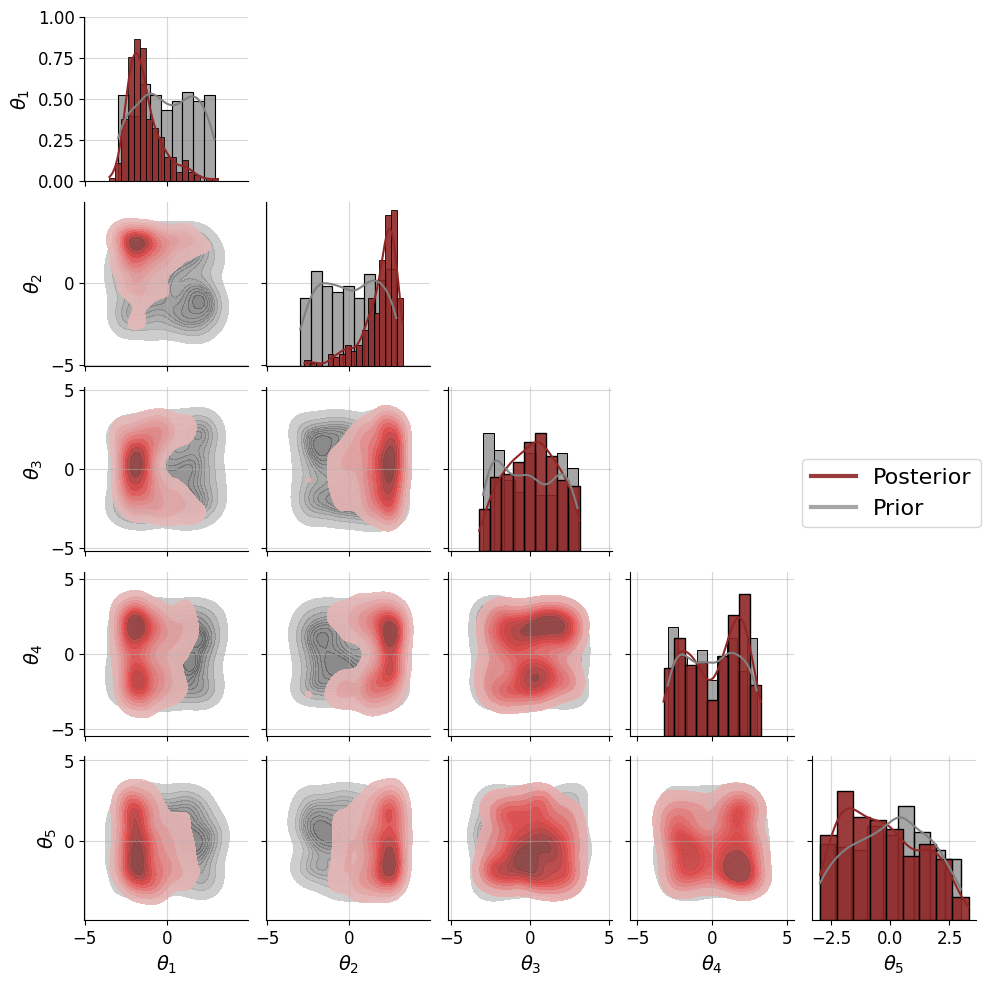

In [22]:
f = plot_posterior_2d(post_samples[0], prior=benchmark.generative_model.prior, height=2)

# Appendix Plots

In [23]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

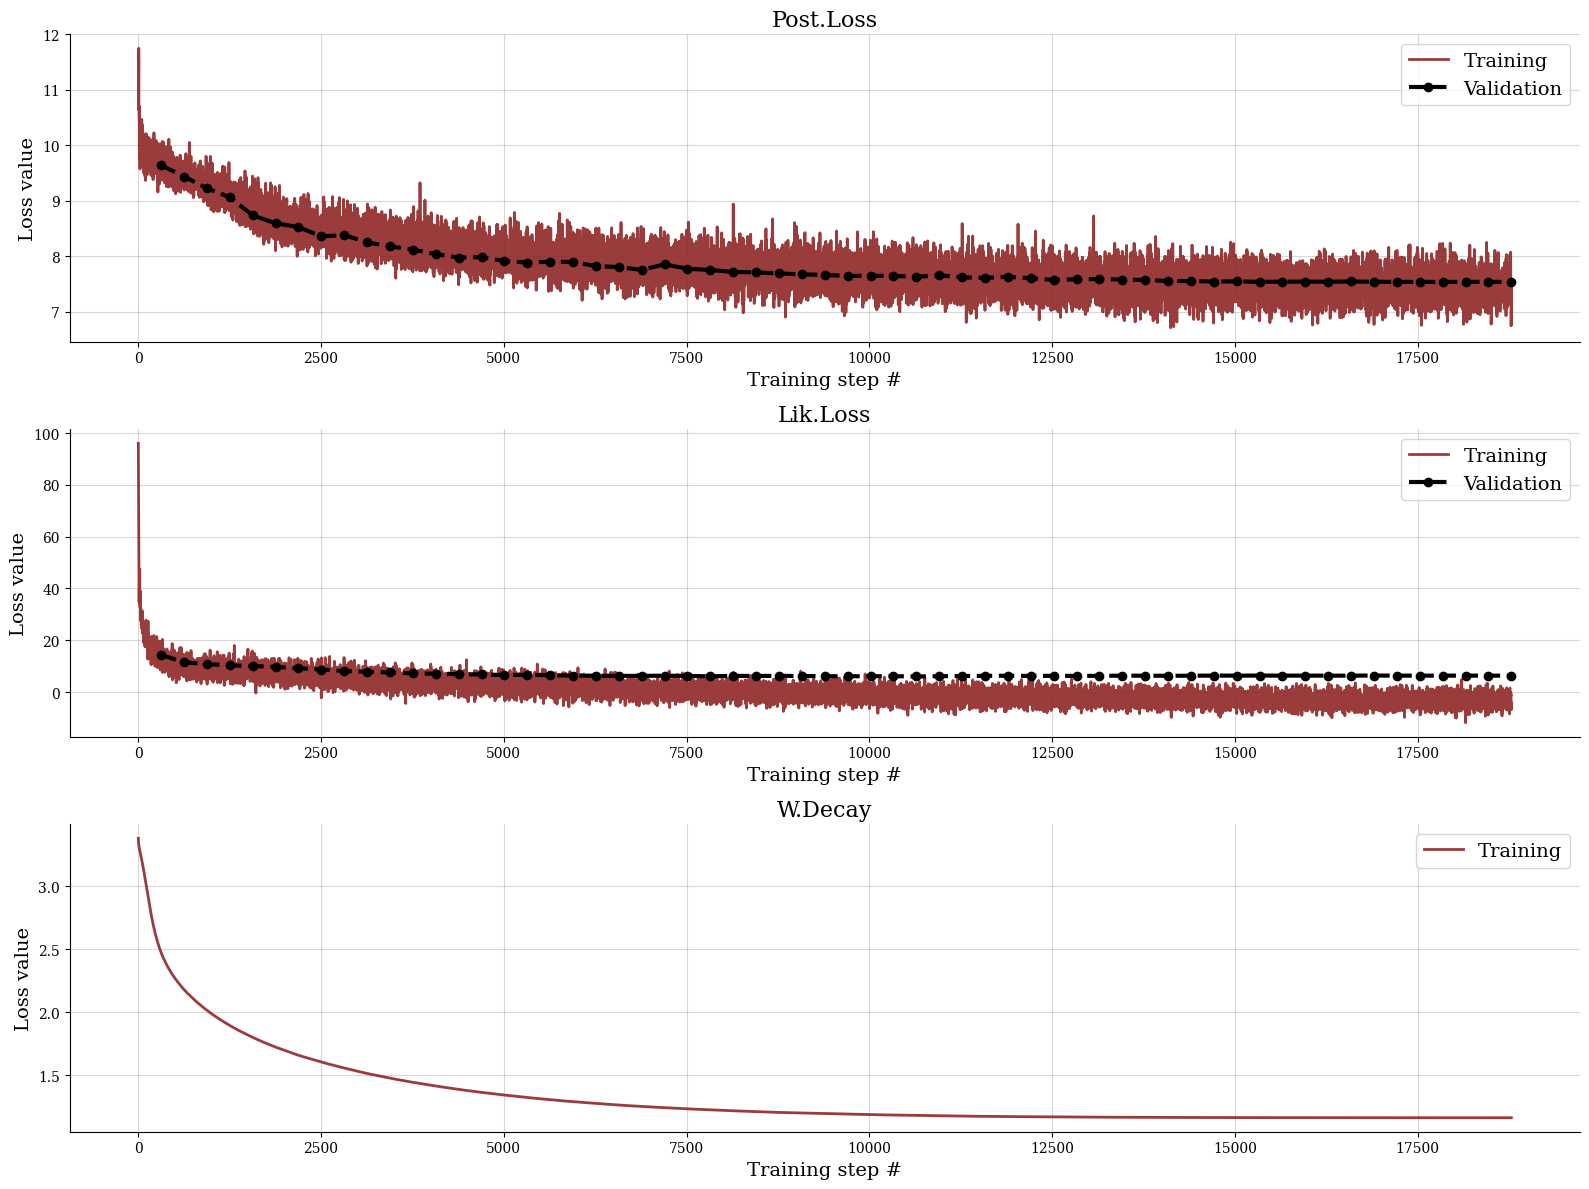

In [24]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

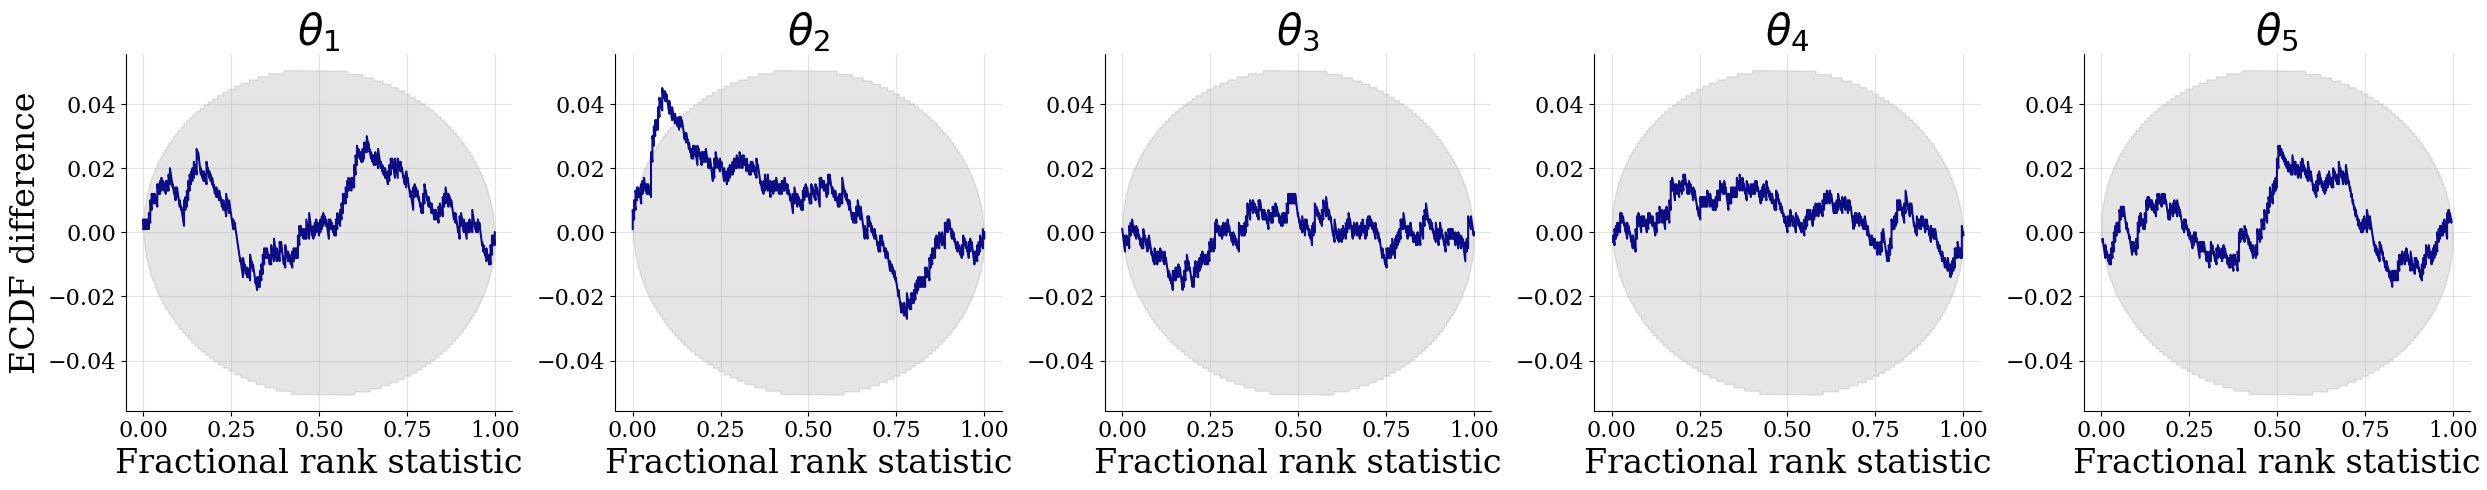

In [25]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

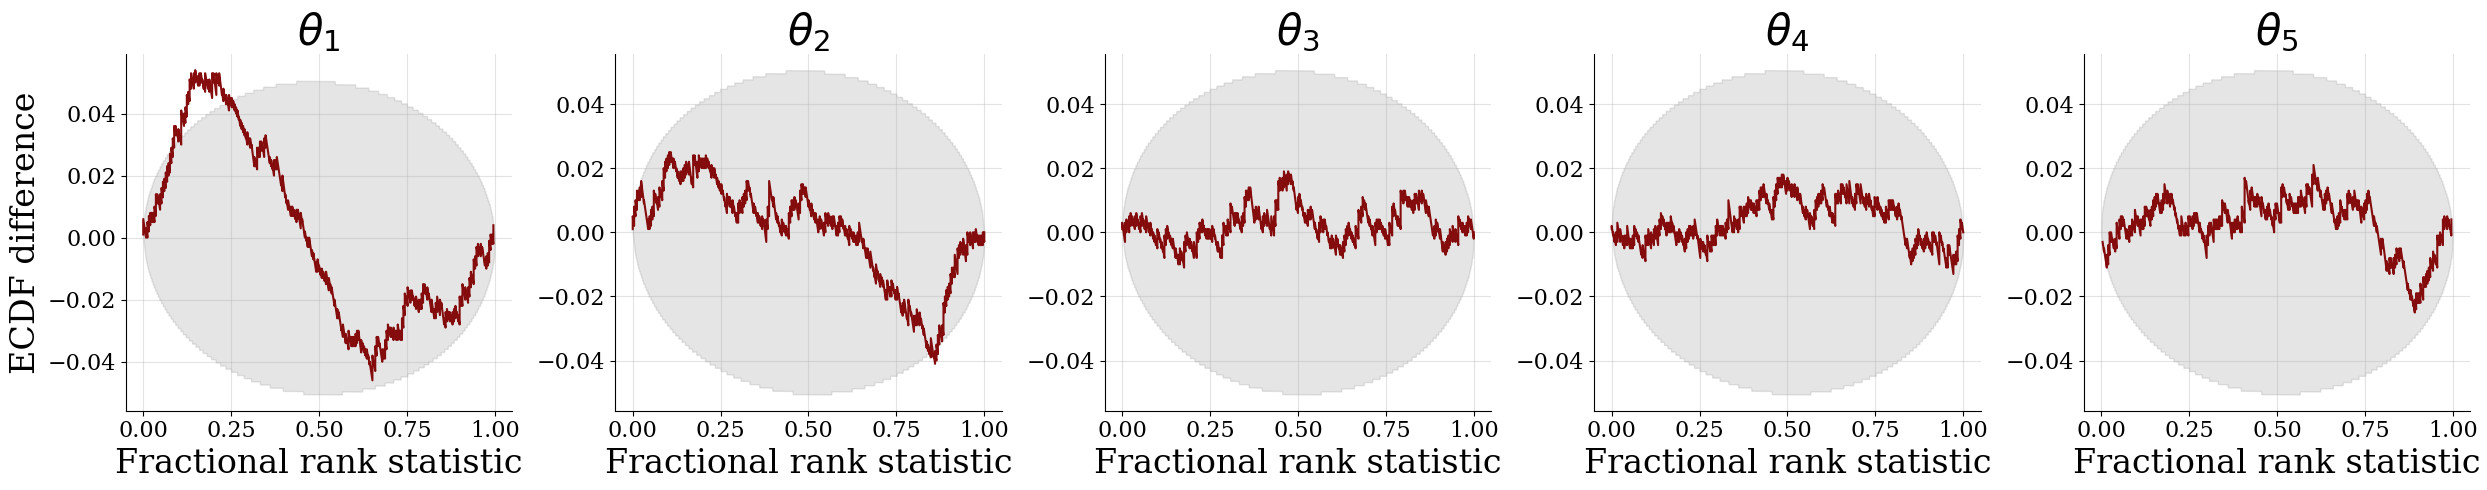

In [26]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")